In [1]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import librosa
import librosa.display
import torch
import torchaudio
import math
import numpy as np
from tqdm import tqdm
import pandas as pd
from PIL import Image

# from utils.file_reader import *


In [2]:
def tensor2numpy(array):
    if torch.is_tensor(array):
        array = array.detach().cpu().numpy().copy()
    return array

def flat(feat):
    feat_size = feat.shape[-1]
    return feat.reshape(-1, feat_size)

def get_xyz(feat):
    feat_flat = flat(feat)
    if not (feat_flat.shape[1] == 3):
        print("error")
    return feat_flat[:, 0], feat_flat[:, 1], feat_flat[:, 2]

def sound_postprocess(sound):
    sound_mel = np.multiply(sound, -80)
    return sound_mel

# Postprocess an observation for storage (from float32 numpy array [-0.5, 0.5] to uint8 numpy array [0, 255])
def postprocess_observation(observation, bit_depth=5):
  return np.clip(np.floor((observation + 0.5) * 2 ** bit_depth) * 2 ** (8 - bit_depth), 0, 2 ** 8 - 1).astype(np.uint8)

def plot_tragectory(data, ax, t, dim=3):
    pos_x, pos_y, pos_z = get_xyz(data[:t])
    if dim == 3:
        ax.plot(pos_x, pos_y, pos_z, marker="x")
    else:
        ax.plot(pos_x, pos_y, marker="x")
    ax.set_xlim(0.2, 0.3)
    ax.set_ylim(0.005, 0.01)
    if dim == 3:
        ax.set_zlim(0.15, 0.25)

def plot_observations(data, plot_dir, file_name, n_frame=None):
    if n_frame == None:
        n_frame = len(data["image_horizon"])

    # fft parameter
    sr = 16000
    fft_size = 1024
    frame_period = 5  # ms
    target_hz = 10
    hop_length = int(0.001 * sr * frame_period)
    frame_num = int((1 / target_hz) / (0.001 * frame_period))

    fig = plt.figure(figsize=(5 * 2, 5 * 2))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3, projection="3d")

    def plot(t):
        plt.cla()
        fig.suptitle("observation t={}".format(t))
        imh = postprocess_observation(data["image_horizon"][t])
        ax1.imshow(imh.transpose(1, 2, 0)[:,:,::-1])
        mlsp = sound_postprocess(data["sound"][t])
        librosa.display.specshow(mlsp, x_axis="ms", y_axis="mel", sr=sr, hop_length=hop_length, ax=ax2)
        plot_tragectory(data["end_effector"], ax3, t)
        ax1.title.set_text("Horizontal Image")
        ax2.title.set_text("Mel-Spectrogram")
        ax3.title.set_text("End-effector Position")

    # create animation 10Hz
    anim = FuncAnimation(fig, plot, frames=n_frame, interval=100)
    save_plot_name = os.path.join(plot_dir, file_name + ".mp4")
    anim.save(save_plot_name, writer="ffmpeg")

In [2]:
rosbag_path = "rosbags"
rosbag_dir_list = os.listdir(rosbag_path)
for dir_name in tqdm(rosbag_dir_list, desc="train dataset"):
    print(dir_name)

train dataset: 100%|██████████| 3/3 [00:00<00:00, 7113.01it/s]

cobotta_2022-01-11-08-24-53
cobotta_2022-01-11-08-17-15
cobotta_2022-01-11-08-21-34


In [4]:
numpy_path = "numpy/2022-03-24"
numpy_dir_list = os.listdir(numpy_path)


def tensor2numpy(array):
    if torch.is_tensor(array):
        array = array.detach().cpu().numpy().copy()
    return array

for numpy_dir in numpy_dir_list:
    observations = {}
    dir_path = os.path.join(numpy_path, numpy_dir)
    n_frame = sum(os.path.isfile(os.path.join(dir_path, name)) for name in os.listdir(dir_path))
    for i in range(n_frame):
        file_path = os.path.join(dir_path, "frame_%05d.npy" % i)
        dict = np.load(file_path, allow_pickle=True).item()
        observation = dict['observations']
        for key in observation.keys():
            if not key in observations.keys():
                observations[key] = tensor2numpy(observation[key])
            else:
                observations[key] = np.concatenate([observations[key], tensor2numpy(observation[key])], axis=0)
    for key in observations.keys():
        print(key)
        print(observations[key].shape)

image_horizon
(494, 3, 64, 64)
sound
(494, 128, 20)
end_effector
(494, 3)
image_horizon
(599, 3, 64, 64)
sound
(599, 128, 20)
end_effector
(599, 3)
image_horizon
(396, 3, 64, 64)
sound
(396, 128, 20)
end_effector
(396, 3)
image_horizon
(825, 3, 64, 64)
sound
(825, 128, 20)
end_effector
(825, 3)
image_horizon
(879, 3, 64, 64)
sound
(879, 128, 20)
end_effector
(879, 3)
image_horizon
(301, 3, 64, 64)
sound
(301, 128, 20)
end_effector
(301, 3)
image_horizon
(597, 3, 64, 64)
sound
(597, 128, 20)
end_effector
(597, 3)
image_horizon
(638, 3, 64, 64)
sound
(638, 128, 20)
end_effector
(638, 3)


KeyboardInterrupt: 

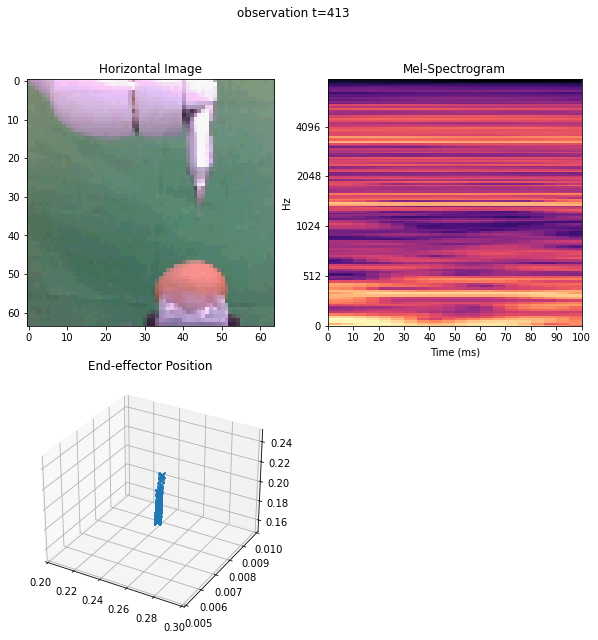

In [22]:
numpy_path = "numpy/2022-03-24"
numpy_dir_list = os.listdir(numpy_path)

results_path = "result"
os.makedirs(results_path, exist_ok=True)

for numpy_dir in numpy_dir_list:
    observations = {}
    dir_path = os.path.join(numpy_path, numpy_dir)
    n_frame = sum(os.path.isfile(os.path.join(dir_path, name)) for name in os.listdir(dir_path))
    for i in range(n_frame):
        file_path = os.path.join(dir_path, "frame_%05d.npy" % i)
        dict = np.load(file_path, allow_pickle=True).item()
        observation = dict['observations']
        for key in observation.keys():
            if not key in observations.keys():
                observations[key] = tensor2numpy(observation[key])
            else:
                observations[key] = np.concatenate([observations[key], tensor2numpy(observation[key])], axis=0)
                
    # n_frame = 1
    plot_observations(observations, results_path, numpy_dir, n_frame)

In [3]:
numpy_path = "numpy/2022-03-24"
numpy_dir_list = os.listdir(numpy_path)

results_path = "result/2022-03-24"
os.makedirs(results_path, exist_ok=True)


def get_latent_state(data, key):
    if key == 'beliefs':
        temp = tensor2numpy(data[key][0])
        for i in range(1, len(data[key])):
            temp = np.concatenate([temp, np.squeeze(tensor2numpy(data[key][i]), axis=0)], axis=0)
        temp = np.expand_dims(temp, axis=0)
    elif key == 'prior_states':
        temp = np.expand_dims(np.expand_dims(tensor2numpy(data['posterior_states'][0]), axis=0), axis=0)
        temp = np.concatenate([temp, tensor2numpy(data[key][1])], axis=1)
    return temp
    


for numpy_dir in numpy_dir_list:
    start_time = 0
    stamps = {}
    observations = {}
    latent_state = {}
    latent_state_keys = ['beliefs', 'prior_states']
    
    dir_path = os.path.join(numpy_path, numpy_dir)
    n_frame = sum(os.path.isfile(os.path.join(dir_path, name)) for name in os.listdir(dir_path))
    for i in range(n_frame):
        file_path = os.path.join(dir_path, "frame_%05d.npy" % i)
        dict = np.load(file_path, allow_pickle=True).item()
        # 'stamp_up', 'stamp_action', 'observations', 'action', 'beliefs', 'prior_states', 'posterior_states'
        # time stamps and action
        if i == 0:
            start_time = dict['stamp_up']
            stamps['uptime'] = np.array(dict['stamp_up'] - start_time, dtype=np.float32)
            stamps['latency'] = np.array(dict['stamp_action'] - dict['stamp_up'], dtype=np.float32)
            actions = np.expand_dims(dict["action"], axis=0)
            # RSSM parameters
            for key in latent_state_keys:
                latent_state[key] = get_latent_state(dict, key)
        else:
            stamps['uptime'] = np.append(stamps['uptime'], dict['stamp_up'] - start_time).astype(np.float32)
            stamps['latency'] = np.append(stamps['latency'], dict['stamp_action'] - dict['stamp_up']).astype(np.float32)
            actions = np.concatenate([actions, np.expand_dims(dict["action"], axis=0)], axis=0)
            for key in latent_state_keys:
                latent_state[key] = np.concatenate([latent_state[key], get_latent_state(dict, key)], axis=0)
        # observation
        observation = dict['observations']
        for obs_key in observation.keys():
            if not obs_key in observations.keys():
                observations[obs_key] = tensor2numpy(observation[obs_key])
            else:
                observations[obs_key] = np.concatenate([observations[obs_key], tensor2numpy(observation[obs_key])], axis=0)
                
    for key in stamps.keys():
        print(key + " : " + str(stamps[key].shape))
    for key in observations.keys():
        print(key + " : " + str(observations[key].shape))
    for key in latent_state_keys:
        print(key + " : " + str(latent_state[key].shape))
    

uptime : (494,)
latency : (494,)
image_horizon : (494, 3, 64, 64)
sound : (494, 128, 20)
end_effector : (494, 3)
beliefs : (494, 2, 200)
prior_states : (494, 2, 30)
uptime : (599,)
latency : (599,)
image_horizon : (599, 3, 64, 64)
sound : (599, 128, 20)
end_effector : (599, 3)
beliefs : (599, 2, 200)
prior_states : (599, 2, 30)
uptime : (396,)
latency : (396,)
image_horizon : (396, 3, 64, 64)
sound : (396, 128, 20)
end_effector : (396, 3)
beliefs : (396, 2, 200)
prior_states : (396, 2, 30)
uptime : (825,)
latency : (825,)
image_horizon : (825, 3, 64, 64)
sound : (825, 128, 20)
end_effector : (825, 3)
beliefs : (825, 2, 200)
prior_states : (825, 2, 30)
uptime : (879,)
latency : (879,)
image_horizon : (879, 3, 64, 64)
sound : (879, 128, 20)
end_effector : (879, 3)
beliefs : (879, 2, 200)
prior_states : (879, 2, 30)
uptime : (301,)
latency : (301,)
image_horizon : (301, 3, 64, 64)
sound : (301, 128, 20)
end_effector : (301, 3)
beliefs : (301, 2, 200)
prior_states : (301, 2, 30)
uptime : (

In [4]:
def flat(feat):
    feat_size = feat.shape[-1]
    return feat.reshape(-1, feat_size)

def get_xyz(feat):
    feat_flat = flat(feat)
    if not (feat_flat.shape[1] == 3):
        print("error")
    return feat_flat[:, 0], feat_flat[:, 1], feat_flat[:, 2]

def plot_ls_traj(ax, traj_rec, traj_imag, t, dim=2):
    x_rec, y_rec, z_rec = get_xyz(traj_rec[:t+1])
    x_imag, y_imag, z_imag = get_xyz(traj_imag[:t+1])
    if dim == 3:
        ax.plot(x_rec, y_rec, z_rec, label="rec", marker="x")
        ax.plot(x_imag, y_imag, z_imag, label="imag", marker="x")
    else:
        ax.plot(x_rec, y_rec, label="rec", marker="x")
        ax.plot(x_imag, y_imag, label="imag", marker="x")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # ax.set_xlabel("X-axis")
    # ax.set_ylabel("Y-axis")
    if dim == 3:
        ax.set_zlim(-10, 10)
        # ax.set_zlabel("Z-axis")
        
def plot_eepos_traj(data, ax, t, dim=3):
    pos_x, pos_y, pos_z = get_xyz(data[:t])
    if dim == 3:
        ax.plot(pos_x, pos_y, pos_z, marker="x")
    else:
        ax.plot(pos_x, pos_y, marker="x")
    ax.set_xlim(0.2, 0.3)
    ax.set_ylim(0.005, 0.01)
    if dim == 3:
        ax.set_zlim(0.15, 0.25)

def plot_ts_line(data, x_key, y_key, ax, t, length=10):
    if t < length:
        data_x = data[x_key][:t]
        data_y = data[y_key][:t]
    else:
        data_x = data[x_key][t-length:t]
        data_y = data[y_key][t-length:t]
    ax.plot(data_x, data_y, marker="x")
    ax.set_xticks(np.arange(min(data_x)-0.1, max(data_x)+0.1, 0.1))
    ax.set_ylim(min(data_y)-0.01, max(data_y)+0.01)
    


def plot_obs_stamp_ls(observations, stamps, latent_state, plot_dir, file_name, n_frame=None, pca_dim = 2):
    if n_frame == None:
        n_frame = len(observations["image_horizon"])

    # fft parameter
    sr = 16000
    fft_size = 1024
    frame_period = 5  # ms
    target_hz = 10
    hop_length = int(0.001 * sr * frame_period)
    frame_num = int((1 / target_hz) / (0.001 * frame_period))
    
    

    fig = plt.figure(figsize=(5 * 3, 5 * 3))
    ax1 = fig.add_subplot(3, 3, 1)
    ax2 = fig.add_subplot(3, 3, 2)        
    if pca_dim == 2:
        ax3 = fig.add_subplot(3, 3, 3)
    elif pca_dim == 3:
        ax3 = fig.add_subplot(3, 3, 3, projection="3d")
    ax4 = fig.add_subplot(3, 3, 4, projection="3d")
    ax5 = fig.add_subplot(3, 3, 5)
    if pca_dim == 2:
        ax6 = fig.add_subplot(3, 3, 6)
    elif pca_dim == 3:
        ax6 = fig.add_subplot(3, 3, 6, projection="3d")
    ax7 = fig.add_subplot(3, 3, 7, projection="3d")

    def plot(t):
        plt.cla()
        
        # Observation
        imh = postprocess_observation(observations["image_horizon"][t])
        ax1.imshow(imh.transpose(1, 2, 0)[:,:,::-1])
        mlsp = sound_postprocess(observations["sound"][t])
        librosa.display.specshow(mlsp, x_axis="ms", y_axis="mel", sr=sr, hop_length=hop_length, ax=ax2)
        plot_eepos_traj(observations["end_effector"], ax4, t)
        
        # stamp
        plot_ts_line(stamps, 'uptime', 'latency', ax=ax5, t=t, length=10)
        
        # latent state
        # TODO : pca_process
        plot_ls_traj(ax=ax3, )
        # TODO : pca_process
        plot_ls_traj(ax=ax6, )
        
        fig.suptitle("observation t={}".format(t))
        ax1.title.set_text("Horizontal Image")
        ax2.title.set_text("Mel-Spectrogram")
        ax3.title.set_text("Deterministic")
        ax4.title.set_text("End-effector Position")
        ax5.title.set_text("Latency")
        ax6.title.set_text("Stochastic")

    # create animation 10Hz
    anim = FuncAnimation(fig, plot, frames=n_frame, interval=100)
    save_plot_name = os.path.join(plot_dir, file_name + ".mp4")
    anim.save(save_plot_name, writer="ffmpeg")

In [7]:
import pickle as pk

pca_belief = pk.load(open('pca/pca_belief.pkl', 'rb'))
pca_post_mean = pk.load(open('pca/pca_post_mean.pkl', 'rb'))

# test = np.zeros((1, 200), dtype=np.float32)
# print(test.shape)
# test = pca_belief.transform(test)
# print(test.shape)
# print(get_xyz(test))

def pca_process(data, key, pca_model):
    shape = data[key].shape[:-1] + (3,)
    result = np.zeros(shape, dtype=np.float32)
    for i in range(shape[0]):
        result[i] = pca_model.transform(data[key][i])
    return result

# 'beliefs', 'prior_states'
clip_belief = pca_process(latent_state, 'beliefs', pca_belief)
clip_prior_states = pca_process(latent_state, 'prior_states', pca_post_mean)

print(clip_belief.shape, clip_prior_states.shape)

(638, 2, 3) (638, 2, 3)


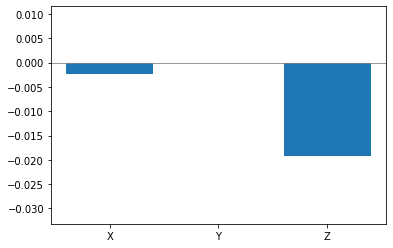

In [27]:
def plot_action_bar(actions, ax, t):
    height = actions[t].flatten()
    x_axis = np.array([1, 2, 3])
    label = ["X", "Y", "Z"]
    ax.bar(x_axis, height, tick_label=label, align="center")
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylim(np.min(actions)-0.005, np.max(actions)+0.005)

fig, ax = plt.subplots()
plot_action_bar(actions, ax, t=0)
fig.show()

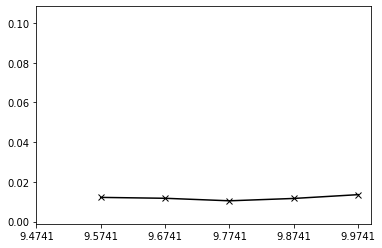

In [5]:
def plot_ts_line(data, x_key, y_key, ax, t, length=10):
    if t < length:
        data_x = data[x_key][: t + 1]
        data_y = data[y_key][: t + 1]
    else:
        data_x = data[x_key][t + 1 - length : t + 1]
        data_y = data[y_key][t + 1 - length : t + 1]
    ax.plot(data_x, data_y, color="k", marker = "x")
    ax.set_xticks(np.arange(min(data_x) - 0.1, max(data_x) + 0.1, 0.1))
    ax.set_ylim(min(data[y_key]) - 0.01, max(data[y_key]) + 0.01)

fig, ax = plt.subplots()
plot_ts_line(stamps, "uptime", "latency", ax=ax, t=100, length=5)
fig.show()

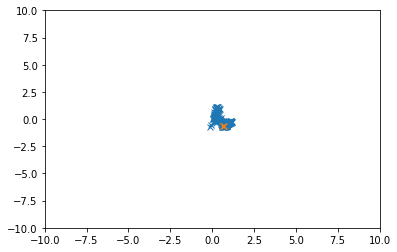

In [13]:
def plot_ls_traj(data, ax, t, dim=2):
    x_rec, y_rec, z_rec = get_xyz(data[:t, 0])
    x_imag, y_imag, z_imag = get_xyz(data[t, :])
    if dim == 3:
        ax.plot(x_rec, y_rec, z_rec, marker="x")
        ax.plot(x_imag, y_imag, z_imag, marker="x")
    else:
        ax.plot(x_rec, y_rec, marker="x")
        ax.plot(x_imag, y_imag, marker="x")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # ax.set_xlabel("X-axis")
    # ax.set_ylabel("Y-axis")
    if dim == 3:
        ax.set_zlim(-10, 10)
        # ax.set_zlabel("Z-axis")


fig, ax = plt.subplots()
plot_ls_traj(clip_belief, ax, t=500, dim=2)
fig.show()

In [4]:
length, freq, frame = observations["sound"].shape
results = np.concatenate([observations["sound"][i] for i in range(length)], axis=1)
print(results.shape)

(128, 12760)


In [5]:
type(observations["sound"])

numpy.ndarray

In [4]:
test = np.zeros(1)
isinstance(test, (np.ndarray, np.generic) )

True